In [89]:
import numpy as np
from sklearn import svm
from sklearn.svm import SVR
from sklearn.svm import SVC
import sklearn.model_selection
import numpy.random as rd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import warnings, pandas as pd,numpy as np, time, math, configparser,random

In [90]:
## 1. GWO optimization algorithm
def sanitized_gwo(X_train,X_test,y_train,y_test,SearchAgents_no,T,dim,lb,ub):
    Alpha_position=[0,0] # Initialize the position of Alpha Wolf
    Beta_position=[0,0]
    Delta_position=[0,0]  

    Alpha_score = float("inf") # Initialize the value of Alpha Wolf's objective function 
    Beta_score = float("inf")
    Delta_score = float("inf")
 
    Positions = np.dot(rd.rand(SearchAgents_no,dim),(ub-lb))+lb # initialize the first search position
    
    Convergence_curve=np.zeros((1,T))# initialization fusion curve

    iterations = []
    accuracy = []

    # Main Loop
    t = 0 
    while t < T:
        
        # Iterate over each wolf
        for i in range(0,(Positions.shape[0])):
            #If the search position exceeds the search space, you need to return to the search space 
            for j in range(0,(Positions.shape[1])): 
                Flag4ub=Positions[i,j]>ub
                Flag4lb=Positions[i,j]<lb
                #If the wolf's position is between the maximum and minimum, the position does not need to be adjusted, if it exceeds the maximum, the maximum returns to the maximum value boundary

                if Flag4ub:                   
                    Positions[i,j] = ub
                if Flag4lb:                   
                    Positions[i,j] = lb
            '''SVM MODEL TRAINING - FOR CLASSIFICATION PROBLEM DATASET''' 
            poly_svm = svm.SVC(kernel = 'poly', C = 1, coef0=Positions[i][0],tol=Positions[i][1]).fit(X_train, y_train)  #svm
            cv_accuracies = cross_val_score(poly_svm,X_test,y_test,cv = 10, scoring = 'accuracy')
            
            '''SVR MODEL TRAINING - FOR REGRESSION PROBLEM DATASET'''
            #rbf_regressor = svm.SVR(kernel = 'rbf', C = Positions[i][0], gamma = Positions[i][1]).fit(X_train, y_train)  #svm        
            #cv_accuracies = cross_val_score(rbf_regressor,X_test,y_test,cv =3,scoring = 'neg_mean_squared_error') # Taking negated value of MSE
            
            
            #To minimize the error rate
            accuracies = cv_accuracies.mean()            
            fitness_value = (1 - accuracies)*100
            if fitness_value<Alpha_score: # If the objective function value is less than the objective function value of Alpha Wolf
                Alpha_score=fitness_value # Then update the target function value of Alpha Wolf to the optimal target function value
                Alpha_position=Positions[i] # At the same time update the position of the Alpha wolf to the optimal position
            if fitness_value>Alpha_score and fitness_value<Beta_score:  # If the objective function value is between the objective function value of Alpha Wolf and Beta Wolf
                Beta_score=fitness_value # Then update the target function value of Beta Wolf to the optimal target function value
                Beta_position=Positions[i]
            if fitness_value>Alpha_score and fitness_value>Beta_score and fitness_value<Delta_score: #If the target function value is between the target function value of Beta Wolf and Delta Wolf
                Delta_score=fitness_value  # Then update the target function value of Delta Wolf to the optimal target function value
                Delta_position=Positions[i]


        a=2-t*(2/T)
        
        # Iterate over each wolf
        for i in range(0,(Positions.shape[0])):
            #Traverse through each dimension
            for j in range(0,(Positions.shape[1])): 
                #Surround prey, location update                 
                r1=rd.random(1)#Generate a random number between 0 ~ 1
                r2=rd.random(1)               
                A1=2*a*r1-a # calculation factor A
                #C1=2*r2 # calculation factor C
                C1 = 0.5 + (0.5*math.exp(-j/500)) + (1.4*(math.sin(j)/30)) # Time varying Acceleration constant 

                #Alphawolf location update
                
                D_alpha=abs(C1*Alpha_position[j]-Positions[i,j])
                X1=Alpha_position[j]-A1*D_alpha
                       
                r1=rd.random(1)
                r2=rd.random(1)

                A2=2*a*r1-a
                #C2=2*r2
                C2  = 1 + (1.4*(1 - math.exp(-j/500)) ) + (1.4*(math.sin(j)/30)) #Difference Mean based Perturbation time varying parameter

                # Beta wolf location update
                D_beta=abs(C2*Beta_position[j]-Positions[i,j])
                X2=Beta_position[j]-A2*D_beta
                r1=rd.random(1)
                r2=rd.random(1)

                A3=2*a*r1-a
                #C3=2*r2
                C3=(1/(1+ math.exp(-0.0001*j/T) )) + ((0.5 - 2.5) * ((j/T) **2)) #sigmoid-based acceleration coefficient

                # Delta Wolf Location Update
                D_delta=abs(C3*Delta_position[j]-Positions[i,j])
                X3=Delta_position[j]-A3*D_delta

                # Location update
                Positions[i,j]=(X1+X2+X3)/3

        
        t = t + 1
        iterations.append(t)
        accuracy.append((100-Alpha_score)/100)
        print('----------------Count of iterations----------------' + str(t))
        print(Positions)
        print('C and coef0:' + str(Alpha_position))
        print('accuracy:' + str((100-Alpha_score)/100))

    best_coef0=Alpha_position[0]
    best_tol=Alpha_position[1]

    return best_coef0,best_tol,iterations,accuracy

In [91]:
# Plot Convergence Curve
def plot(iterations,accuracy):
    plt.plot(iterations,accuracy)
    plt.xlabel('Count of iterations',size = 20)
    plt.ylabel('Accuracy',size = 20)
    plt.title('Sanitized GWO-SVM parameter optimization (SGWO_SVM)')
    plt.show()

In [92]:
if __name__ == '__main__':
    print('----------------1. Load data-------------------')
    file_name="C:/Users/HP/Desktop/Hepatemiz.csv"
    df=pd.read_csv(file_name)
    df=df.drop("Unnamed: 0",axis=1)
    y=df.Class
    X=df.drop('Class',axis=1)
    X_train,X_test,y_train,y_test= train_test_split(X, y, test_size = 0.33, random_state = 0)

----------------1. Load data-------------------


In [93]:
df.dtypes

Class               int64
AGE                 int64
SEX                 int64
STEROID             int64
ANTIVIRALS          int64
FATIGUE             int64
MALAISE             int64
ANOREXIA            int64
LIVERBIG            int64
LIVERFIRM           int64
SPLEENPALPABLE      int64
SPIDERS             int64
ASCITES             int64
VARICES             int64
BILIRUBIN         float64
ALKPHOSPHATE      float64
SGOT              float64
ALBUMIN           float64
PROTIME           float64
HISTOLOGY           int64
dtype: object

In [94]:
df = df.astype({"Class": "category", "SEX": "category"})
df = df.astype({"STEROID": "category", "ANTIVIRALS": "category"})
df = df.astype({"FATIGUE": "category", "MALAISE": "category"})
df = df.astype({"ANOREXIA": "category", "LIVERBIG": "category"})
df = df.astype({"LIVERFIRM": "category", "SPLEENPALPABLE": "category"})
df = df.astype({"SPIDERS": "category", "ASCITES": "category"})
df = df.astype({"VARICES": "category", "BILIRUBIN": "float64"})
df = df.astype({"ALBUMIN": "float64", "SGOT": "category"})
df = df.astype({"PROTIME": "int64", "ALKPHOSPHATE": "int64"})
df = df.astype({"HISTOLOGY": "category"})



In [95]:
df.dtypes

Class             category
AGE                  int64
SEX               category
STEROID           category
ANTIVIRALS        category
FATIGUE           category
MALAISE           category
ANOREXIA          category
LIVERBIG          category
LIVERFIRM         category
SPLEENPALPABLE    category
SPIDERS           category
ASCITES           category
VARICES           category
BILIRUBIN          float64
ALKPHOSPHATE         int64
SGOT              category
ALBUMIN            float64
PROTIME              int64
HISTOLOGY         category
dtype: object

In [96]:
print('----------------2. Parameter setting------------')
SearchAgents_no=19 #Number of Wolfs
T=20 # maximum number of iterations
dim=2 #Need to optimize two variables - Cost and Gamma
lb=0.01 #lower bound Parameter
ub=10 #upper bound Paramete

----------------2. Parameter setting------------


----------------3.LARGE-----------------
----------------Count of iterations----------------1
[[ 1.82840558  0.45770716]
 [ 4.02147226 -3.34626832]
 [-0.11215973  2.56513612]
 [ 8.82654428  3.21858605]
 [ 0.13804125 -1.08377732]
 [ 0.66407814  7.62681113]
 [ 4.91814524  4.00333596]
 [ 4.33209372  0.66473895]
 [ 0.02041961  3.43693815]
 [ 9.03959446  2.29620095]
 [-0.06934571  3.43131927]
 [-0.01456074  2.4284517 ]
 [ 0.06016401  4.52820682]
 [-5.67041274  1.8506153 ]
 [ 1.00732188  3.10912659]
 [-4.97539643  6.76388057]
 [ 2.38740559  2.03370199]
 [-0.13231209  0.12251553]
 [-0.94037388  4.32880917]]
C and coef0:[-0.06934571  3.43131927]
accuracy:0.8133333333333332
----------------Count of iterations----------------2
[[ 1.74733175e+00  3.27757591e+00]
 [ 7.90294586e-01  7.26798672e-01]
 [ 8.72027678e-03  3.53213102e+00]
 [ 1.24676675e+00  3.24989919e+00]
 [ 9.01531597e-03  6.50962847e+00]
 [-5.65396515e-02 -3.32824900e+00]
 [ 6.20430112e+00  2.92792734e+00]
 [ 2.31092016e+00  2.3730062

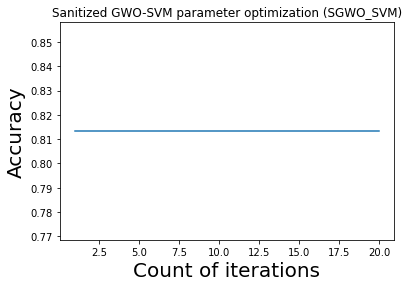

In [97]:
print('----------------3.LARGE-----------------')
best_coef0,best_tol,iterations,accuracy = sanitized_gwo(X_train,X_test,y_train,y_test,SearchAgents_no,T,dim,lb,ub)

print('----------------4. The result shows-----------------')
print("The best coef0 is " + str(best_coef0))
print("The best tol is " + str(best_tol))
plot(iterations,accuracy)

In [98]:
#Apply Optimal Parameters to SVC
svc= SVC(kernel = 'poly', C = 1, coef0=best_coef0, tol=best_tol)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
# APPLYING K-FOLD CROSS VALIDATION on RF model
accuracies = cross_val_score(svc, X = X_train, y = y_train, cv = 10)
accuracy_mean= accuracies.mean()
accuracies.std()*100

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2=r2_score(y_test, y_pred)
nrmse=rmse/(y_test.max() - y_test.min())
print("SVC RESULTS - coef0 AND tol PARAMETERS OPTIMIZED BY GRAY WOLF OPTIMIZATION")
print("RMSE =", rmse)
print("MSE =", mse)
print("Normalized RMSE=",nrmse)
print("R Square =",r2)
print("K-fold accuracy mean",accuracy_mean)

SVC RESULTS - coef0 AND tol PARAMETERS OPTIMIZED BY GRAY WOLF OPTIMIZATION
RMSE = 0.5
MSE = 0.25
Normalized RMSE= 0.5
R Square = -0.408333333333333
K-fold accuracy mean 0.7954545454545455


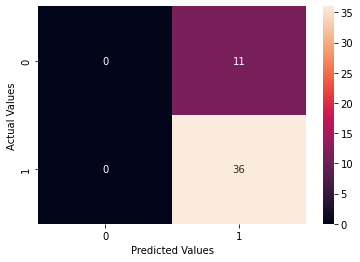

In [34]:
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
cm1 = cm(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()